# Asset Management - HW1

### S&P 500 Index

Extracted data to get the following columns: PERMNO, Date, Exchange Code, Ticker, Company, Price, Shares Outstanding, Cumulative Factor to Adjust Price, Cumulative Factor to Adjust Shares.


***Note: I set a conditional statement to pull data with Exchange Code equals 1, 2, or 3 so companies only on the NYSE, NASDAQ, or AMEX will be included in the data.***

In [1]:
from pandas import Series, DataFrame
import numpy as np
import pandas as pd
%pylab inline
import statsmodels.api as sm
from patsy import dmatrices
from datetime import datetime


df = pd.read_csv('/Users/matthewstreichler/Desktop/MSBA/Fall Semester/FIN 394.1 - FIN 397.1/Asset Management - Sciaraffia/Homework/HW1/hw1_data.csv')
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d", errors="ignore").dt.to_period("M")
df.rename(columns={"COMNAM":"company", "PRC":"price", "SHROUT":"shares", "CFACPR":"price adj", "CFACSHR":"shares adj"}, inplace=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
df["price adjusted"] = df["price"] / df["price adj"]
df["shares adjusted"] = df["shares"] * df["shares adj"] * 1000
df["mkt cap"] = (df["price adjusted"] * df["shares adjusted"]).replace([np.inf, -np.inf], np.nan)
df = df.dropna().reset_index(drop=True)

df = df.drop(["price", "shares", "price adj", "shares adj"], axis=1)
df

,PERMNO,date,EXCHCD,TICKER,company,price adjusted,shares adjusted,mkt cap
0,10001,2009-12,2,EGAS,ENERGY INC,10.30000,4361000.0,4.491830e+07
1,10001,2010-01,2,EGAS,ENERGY INC,10.06000,4361000.0,4.387166e+07
2,10001,2010-02,2,EGAS,ENERGY INC,10.00840,4361000.0,4.364663e+07
3,10001,2010-03,2,EGAS,ENERGY INC,10.17000,4361000.0,4.435137e+07
4,10001,2010-04,2,EGAS,ENERGY INC,11.39000,6070000.0,6.913730e+07
...,...,...,...,...,...,...,...,...
688461,93436,2019-08,3,TSLA,TESLA INC,225.61000,179127000.0,4.041284e+10
688462,93436,2019-09,3,TSLA,TESLA INC,240.87000,180000000.0,4.335660e+10
688463,93436,2019-10,3,TSLA,TESLA INC,314.92001,180245000.0,5.676276e+10
688464,93436,2019-11,3,TSLA,TESLA INC,329.94000,180245000.0,5.947004e+10


In [3]:
def reconstitute(x):
    
    # Gets the top 500 companies based on market capitalization
    x = x.sort_values(by="mkt cap", ascending=False)[:500].reset_index(drop=True)
    x = rebalance(x)
    return x
    
def rebalance(x):
    
    # Finds the weight by dividing market cap by the total market cap
    x["weight"] = x["mkt cap"] / x["mkt cap"].sum()
    return x

In [4]:
# Gets list of all unique dates
dates = df["date"].unique()

# Creating the S&P 500 dataframe
column = ["date", "PERMNO", "TICKER", "mkt cap", "weight"]
sp500 = pd.DataFrame(np.zeros((0, len(column))), columns = column)
sp500_final = pd.DataFrame(np.zeros((505, len(column))), columns = column)

for i in dates:
    
    # Puts all information from same date into a dataframe
    date_df = df[df["date"] == i][["date", "PERMNO", "TICKER", "price adjusted", "mkt cap"]]
    
    # Checking to see if it is at year end --> reconstitute annually
    if i.month%12 == 0:
        sp500_final = reconstitute(date_df)
        const = sp500_final[["PERMNO"]]
    
    # Checking to see if it is at quarter end --> rebalance quarterly
    elif i.month%3 == 0:
        date_df = date_df.merge(const)
        sp500_final = rebalance(date_df)
    
    # If not at quarter or year end --> keep weights the same
    else:
        columns = ["date", "PERMNO", "TICKER", "price adjusted", "mkt cap", "weight"]
        date_df = date_df.merge(const, how="left")
        sp500_final = sp500_final.drop(columns=["date", "mkt cap"])
        sp500_final = sp500_final.merge(date_df[["date", "PERMNO", "mkt cap"]], how="left", left_on="PERMNO", right_on="PERMNO")[columns]
        
    sp500 = sp500.append(sp500_final).reset_index(drop=True)
    
sp500

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,PERMNO,TICKER,date,mkt cap,price adjusted,weight
0,11850.0,XOM,2009-12,3.226681e+11,68.19000,0.027501
1,10107.0,MSFT,2009-12,2.685593e+11,30.48000,0.022890
2,55976.0,WMT,2009-12,2.036537e+11,53.45000,0.017358
3,14593.0,AAPL,2009-12,1.909826e+11,30.10457,0.016278
4,22111.0,JNJ,2009-12,1.777136e+11,64.41000,0.015147
...,...,...,...,...,...,...
59997,91547.0,LDOS,2019-12,1.385770e+10,97.89000,0.000451
59998,85763.0,WPC,2019-12,1.378897e+10,80.04000,0.000449
59999,79698.0,IT,2019-12,1.378471e+10,154.10001,0.000449
60000,40272.0,IFF,2019-12,1.377688e+10,129.02000,0.000448


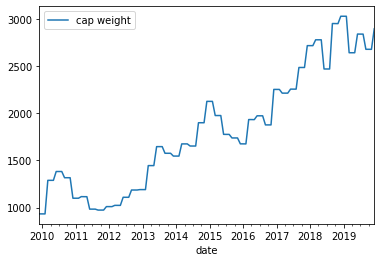

In [5]:
# Calculating the actual price per stock
sp500["cap weight"] = sp500["price adjusted"] * sp500["weight"]

# Grouping all stocks by date to show general trend of S&P 500
my_sp = sp500.groupby(["date"])[["cap weight"]].sum()
my_sp.plot()

In [6]:
# Calculating returns - monthly
today = my_sp["cap weight"]
yesterday = today.shift(1)
my_sp["return"] = (today - yesterday) / yesterday

# Annual return
my_sp_ret = (1 + my_sp["return"].mean())**12 - 1

# Calculating standard deviation - annual
my_sp_std = my_sp["return"].std() * sqrt(12)

# Calculating sharpe ratio
# Assuming risk-free rate = 0.02
rf = 0.02
my_sp_sharpe = (my_sp_ret - rf) / my_sp_std

In [7]:
# Putting our information into a dataframe
sp_annual_metrics = pd.DataFrame(data={"Ann. Return":[my_sp_ret], "Ann. Stdev":[my_sp_std], "Ann. Sharpe":[my_sp_sharpe]})
metrics = sp_annual_metrics.rename({0:"My S&P 500"})
metrics

,Ann. Return,Ann. Stdev,Ann. Sharpe
My S&P 500,0.145292,0.22264,0.562756


In [2]:
# Compare our results to a Mutual Fund (VFIAX)
sp_mutual = pd.read_csv('/Users/matthewstreichler/Desktop/MSBA/Fall Semester/FIN 394.1 - FIN 397.1/Asset Management - Sciaraffia/Homework/HW1/sp_mutual.csv')
sp_mutual["caldt"] = pd.to_datetime(sp_mutual["caldt"], format="%Y%m%d", errors="ignore").dt.to_period("M")
sp_mutual.rename(columns={"caldt":"date", "mtna":"month net assets", "mret":"month ret", "mnav":"month nav"}, inplace=True)
sp_mutual = sp_mutual.drop_duplicates(subset="date", keep="first")
sp_mutual = sp_mutual.drop(["crsp_fundno", "month net assets"], axis=1)
sp_mutual = sp_mutual.set_index("date")
sp_mutual["month nav"] = sp_mutual["month nav"] * 10


# Compare our results to the actual S&P 500 Index
sp_index = pd.read_csv('/Users/matthewstreichler/Desktop/MSBA/Fall Semester/FIN 394.1 - FIN 397.1/Asset Management - Sciaraffia/Homework/HW1/sp_index.csv')
sp_index["caldt"] = pd.to_datetime(sp_index["caldt"], format="%Y%m%d", errors="ignore").dt.to_period("M")
sp_index.rename(columns={"caldt":"date", "sprtrn":"month ret", "spindx":"sp level"}, inplace=True)
sp_index = sp_index.set_index("date")


# Compare our results to an ETF (SPY)
sp_etf = pd.read_csv('/Users/matthewstreichler/Desktop/MSBA/Fall Semester/FIN 394.1 - FIN 397.1/Asset Management - Sciaraffia/Homework/HW1/sp_etf.csv')
sp_etf["date"] = pd.to_datetime(sp_etf["date"], format="%Y%m%d", errors="ignore").dt.to_period("M")
sp_etf.rename(columns={"COMNAM":"company", "PRC":"price", "SHROUT":"shares", "CFACPR":"price adj", "CFACSHR":"shares adj"}, inplace=True)
sp_etf = sp_etf.set_index("date")

sp_etf["price adjusted"] = sp_etf["price"] / sp_etf["price adj"] * 10
sp_etf = sp_etf.drop(["price", "shares", "price adj", "shares adj"], axis=1)

In [9]:
# Assuming risk-free rate = 0.02
rf = 0.02

# Calculating returns - monthly
today = sp_etf["price adjusted"]
yesterday = today.shift(1)
sp_etf["return"] = (today - yesterday) / yesterday

# Annual return
sp_mutual["month ret"] = sp_mutual["month ret"].astype(float)
sp_mf_ret = (1 + sp_mutual["month ret"].mean())**12 - 1
sp_index_ret = (1 + sp_index["month ret"].mean())**12 - 1
sp_etf_ret = (1 + sp_etf["return"].mean())**12 - 1

# Calculating standard deviation - annual
sp_mf_std = sp_mutual["month ret"].std() * sqrt(12)
sp_index_std = sp_index["month ret"].std() * sqrt(12)
sp_etf_std = sp_etf["return"].std() * sqrt(12)

# Calculating sharpe ratio
sp_mf_sharpe = (sp_mf_ret - rf) / sp_mf_std
sp_index_sharpe = (sp_index_ret - rf) / sp_index_std
sp_etf_sharpe = (sp_etf_ret - rf) / sp_etf_std

In [10]:
# Putting Mutual Fund information into dataframe
sp_mf_metrics = pd.DataFrame(data={"Ann. Return":[sp_mf_ret], "Ann. Stdev":[sp_mf_std], "Ann. Sharpe":[sp_mf_sharpe]})
metrics = metrics.append(sp_mf_metrics.rename({0:"Mutual Fund (VFIAX)"}))

# Putting S&P Index information into dataframe
sp_index_metrics = pd.DataFrame(data={"Ann. Return":[sp_index_ret], "Ann. Stdev":[sp_index_std], "Ann. Sharpe":[sp_index_sharpe]})
metrics = metrics.append(sp_index_metrics.rename({0:"Actual S&P 500"}))

# Putting SPY ETF information into dataframe
sp_etf_metrics = pd.DataFrame(data={"Ann. Return":[sp_etf_ret], "Ann. Stdev":[sp_etf_std], "Ann. Sharpe":[sp_etf_sharpe]})
metrics = metrics.append(sp_etf_metrics.rename({0:"ETF (SPY)"}))
metrics

,Ann. Return,Ann. Stdev,Ann. Sharpe
My S&P 500,0.145292,0.222640,0.562756
Mutual Fund (VFIAX),0.144832,0.124058,1.006236
Actual S&P 500,0.121668,0.124094,0.819283
ETF (SPY),0.120438,0.124805,0.804758


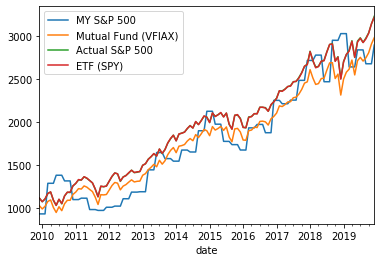

In [11]:
# Plotting my S&P 500, the actual S&P 500 Index, a Mutual Fund, and an ETF
my_sp["cap weight"].plot(label="MY S&P 500")
sp_mutual["month nav"].plot(label="Mutual Fund (VFIAX)")
sp_index["sp level"].plot(label="Actual S&P 500")
sp_etf["price adjusted"].plot(label="ETF (SPY)")
legend(loc="best")

In the above plot, you are unable to see the level of the actual S&P 500 (green line) as SPY (red line) very closely matches it.

***Note: the values in the above plot were scaled so that we are able to see the relationships/trends between one another***

In [12]:
# Correlation matrix between my S&P 500, the actual S&P 500 Index, a Mutual Fund, and an ETF
sp_return_corr = pd.DataFrame(data={"My S&P 500":my_sp["return"], "Mutual Fund (VFIAX)":sp_mutual["month ret"], "Actual S&P 500":sp_index["month ret"], "ETF (SPY)":sp_etf["return"]})
sp_return_corr.corr()

,My S&P 500,Mutual Fund (VFIAX),Actual S&P 500,ETF (SPY)
My S&P 500,1.000000,0.084327,0.085428,0.070439
Mutual Fund (VFIAX),0.084327,1.000000,0.999879,0.997580
Actual S&P 500,0.085428,0.999879,1.000000,0.997276
ETF (SPY),0.070439,0.997580,0.997276,1.000000


### Dow Jones Industrial Average Index

In [13]:
dj = pd.read_csv('/Users/matthewstreichler/Desktop/MSBA/Fall Semester/FIN 394.1 - FIN 397.1/Asset Management - Sciaraffia/Homework/HW1/djia.csv')
dj["date"] = pd.to_datetime(dj["date"], format="%Y%m%d", errors="ignore").dt.to_period("M")
dj.rename(columns={"COMNAM":"company", "PRC":"price", "SHROUT":"shares", "CFACPR":"price adj", "CFACSHR":"shares adj"}, inplace=True)

dj["price adjusted"] = dj["price"] / dj["price adj"]
dj["shares adjusted"] = dj["shares"] * dj["shares adj"] * 1000
#dj["weight"] = dj["price adjusted"].replace([np.inf,-np.inf],np.nan)
dj = dj.drop(["price", "shares", "price adj", "shares adj"], axis=1)
dj

,PERMNO,date,TICKER,company,price adjusted,shares adjusted
0,10107,2009-12,MSFT,MICROSOFT CORP,30.4800,8.811000e+09
1,10107,2010-01,MSFT,MICROSOFT CORP,28.1800,8.770461e+09
2,10107,2010-02,MSFT,MICROSOFT CORP,28.6700,8.770461e+09
3,10107,2010-03,MSFT,MICROSOFT CORP,29.2875,8.762000e+09
4,10107,2010-04,MSFT,MICROSOFT CORP,30.5350,8.763839e+09
...,...,...,...,...,...,...
3723,89006,2019-08,MDLZ,MONDELEZ INTERNATIONAL INC,55.2200,1.442151e+09
3724,89006,2019-09,MDLZ,MONDELEZ INTERNATIONAL INC,55.3200,1.440676e+09
3725,89006,2019-10,MDLZ,MONDELEZ INTERNATIONAL INC,52.4500,1.439824e+09
3726,89006,2019-11,MDLZ,MONDELEZ INTERNATIONAL INC,52.5400,1.439824e+09


In [14]:
def dj_reconstitute(x):
    
    # Gets the top 30 companies based on price
    x = x.sort_values(by="price adjusted", ascending=False)[:30].reset_index(drop=True)
    x = dj_rebalance(x)
    return x
    
def dj_rebalance(x):
    
    # Finds the weight by dividing price adjusted by the total price adjusted
    x["weight"] = x["price adjusted"] #/ x["price adjusted"].sum()
    return x

In [15]:
# Gets list of all unique dates
dates = dj["date"].unique()

# Creating the DJIA dataframe
column = ["date", "PERMNO", "TICKER", "weight"]
djia = pd.DataFrame(np.zeros((0, len(column))), columns = column)
djia_final = pd.DataFrame(np.zeros((30, len(column))), columns = column)

for i in dates:
    
    # Puts all information from same date into a dataframe
    dj_date_df = dj[dj["date"] == i][["date", "PERMNO", "TICKER", "price adjusted", "shares adjusted"]]
    
    # Checking to see if it is at year end --> reconstitute annually
    if i.month%12 == 0:
        djia_final = dj_reconstitute(dj_date_df)
        const = djia_final[["PERMNO"]]
    
    # Checking to see if it is at quarter end --> rebalance quarterly
    elif i.month%3 == 0:
        dj_date_df = dj_date_df.merge(const)
        djia_final = dj_rebalance(dj_date_df)
    
    # If not at quarter or year end --> keep weights the same
    else:
        columns = ["date", "PERMNO", "TICKER", "price adjusted", "weight"]
        dj_date_df = dj_date_df.merge(const, how="left")
        djia_final = djia_final.drop(columns=["date"])
        djia_final = djia_final.merge(dj_date_df[["date", "PERMNO"]], how="left", left_on="PERMNO", right_on="PERMNO")[columns]
        
    djia = djia.append(djia_final).reset_index(drop=True)
    
djia

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,PERMNO,TICKER,date,price adjusted,shares adjusted,weight
0,12490.0,IBM,2009-12,130.89999,1.313603e+09,130.89999
1,22592.0,MMM,2009-12,82.67000,7.079580e+08,82.67000
2,14541.0,CVX,2009-12,76.99000,2.006268e+09,76.99000
3,17830.0,UTX,2009-12,69.41000,9.375390e+08,69.41000
4,11850.0,XOM,2009-12,68.19000,4.731898e+09,68.19000
...,...,...,...,...,...,...
3622,59408.0,BAC,2019-12,35.22000,8.995107e+09,35.22000
3623,24643.0,ARNC,2019-12,30.77000,4.329410e+08,30.77000
3624,16347.0,AA,2019-12,21.51000,1.855730e+08,21.51000
3625,27828.0,HPQ,2019-12,20.55000,1.453187e+09,20.55000


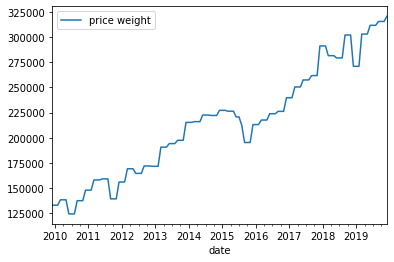

In [16]:
div = 0.15
my_dj = djia.groupby(by="date")[["price adjusted"]].sum()
my_dj["price weight"] = my_dj["price adjusted"] / div
my_dj = my_dj.drop(["price adjusted"], axis=1)
my_dj["price weight"] = my_dj["price weight"] * 15
my_dj.plot()

In [17]:
# Calculating returns - monthly
today = my_dj["price weight"]
yesterday = today.shift(1)
my_dj["return"] = (today - yesterday) / yesterday

# Annual return
my_dj_ret = (1 + my_dj["return"].mean())**12 - 1

# Calculating standard deviation - annual
my_dj_std = my_dj["return"].std() * sqrt(12)

# Calculating sharpe ratio
# Assuming risk-free rate = 0.02
rf = 0.02
my_dj_sharpe = (my_dj_ret - rf) / my_dj_std

In [18]:
# Putting our information into a dataframe
dj_annual_metrics = pd.DataFrame(data={"Ann. Return":[my_dj_ret], "Ann. Stdev":[my_dj_std], "Ann. Sharpe":[my_dj_sharpe]})
dj_metrics = dj_annual_metrics.rename({0:"My DJIA"})
dj_metrics

,Ann. Return,Ann. Stdev,Ann. Sharpe
My DJIA,0.100301,0.126463,0.634979


In [19]:
# Compare our results to the actual DJIA Index
dj_index = pd.read_csv('/Users/matthewstreichler/Desktop/MSBA/Fall Semester/FIN 394.1 - FIN 397.1/Asset Management - Sciaraffia/Homework/HW1/dj_index.csv')
dj_index["date"] = pd.to_datetime(dj_index["date"], format="%Y%m%d", errors="ignore").dt.to_period("M")
dj_index.rename(columns={"prccm":"price", "conm":"company"}, inplace=True)
dj_index = dj_index.drop(["gvkeyx", "tic"], axis=1)
dj_index = dj_index.set_index("date")
dj_index["price adjusted"] = dj_index["price"] * 10

# Compare our results to a Mutual Fund (RYDHX)
dj_mutual = pd.read_csv('/Users/matthewstreichler/Desktop/MSBA/Fall Semester/FIN 394.1 - FIN 397.1/Asset Management - Sciaraffia/Homework/HW1/dj_mutual.csv')
dj_mutual.rename(columns={"caldt":"date", "mret":"month ret"}, inplace=True)
dj_mutual["date"] = pd.to_datetime(dj_mutual["date"], format="%Y%m%d", errors="ignore").dt.to_period("M")
dj_mutual = dj_mutual.drop(["crsp_fundno", "mtna"], axis=1)
dj_mutual = dj_mutual.set_index("date")
dj_mutual["month ret"].iloc[0] = np.nan
dj_mutual["mnav"] = dj_mutual["mnav"] * 3800

# Compare our results to an ETF (DIA)
dj_etf = pd.read_csv('/Users/matthewstreichler/Desktop/MSBA/Fall Semester/FIN 394.1 - FIN 397.1/Asset Management - Sciaraffia/Homework/HW1/dj_etf.csv')
dj_etf.rename(columns={"prccm":"price", "conm":"company", "datadate":"date"}, inplace=True)
dj_etf["date"] = pd.to_datetime(dj_etf["date"], format="%Y%m%d", errors="ignore").dt.to_period("M")
dj_etf = dj_etf.drop(["gvkey", "iid", "trfm", "trt1m", "cshom", "tic"], axis=1)
dj_etf = dj_etf.set_index("date")
dj_etf["price adjusted"] = dj_etf["price"] * 1000

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
# Assuming risk-free rate = 0.02
rf = 0.02

# Calculating returns - monthly
# ETF (DIA)
today_etf = dj_etf["price adjusted"]
yesterday_etf = today_etf.shift(1)
dj_etf["return"] = (today_etf - yesterday_etf) / yesterday_etf
# Actual DJIA Index
today_dj = dj_index["price"]
yesterday_dj = today_dj.shift(1)
dj_index["return"] = (today_dj - yesterday_dj) / yesterday_dj

# Annual return
dj_mutual["month ret"] = dj_mutual["month ret"].astype(float)
dj_mf_ret = (1 + dj_mutual["month ret"].mean())**12 - 1
dj_index_ret = (1 + dj_index["return"].mean())**12 - 1
dj_etf_ret = (1 + dj_etf["return"].mean())**12 - 1

# Calculating standard deviation - annual
dj_mf_std = dj_mutual["month ret"].std() * sqrt(12)
dj_index_std = dj_index["return"].std() * sqrt(12)
dj_etf_std = dj_etf["return"].std() * sqrt(12)

# Calculating sharpe ratio
dj_mf_sharpe = (dj_mf_ret - rf) / dj_mf_std
dj_index_sharpe = (dj_index_ret - rf) / dj_index_std
dj_etf_sharpe = (dj_etf_ret - rf) / dj_etf_std

In [21]:
# Putting Mutual Fund (RYDHX) information into dataframe
dj_mf_metrics = pd.DataFrame(data={"Ann. Return":[dj_mf_ret], "Ann. Stdev":[dj_mf_std], "Ann. Sharpe":[dj_mf_sharpe]})
dj_metrics = dj_metrics.append(dj_mf_metrics.rename({0:"Mutual Fund (RYDHX)"}))

# Putting DJIA Index information into dataframe
dj_index_metrics = pd.DataFrame(data={"Ann. Return":[dj_index_ret], "Ann. Stdev":[dj_index_std], "Ann. Sharpe":[dj_index_sharpe]})
dj_metrics = dj_metrics.append(dj_index_metrics.rename({0:"Actual DJIA"}))

# Putting ETF (DIA) information into dataframe
dj_etf_metrics = pd.DataFrame(data={"Ann. Return":[dj_etf_ret], "Ann. Stdev":[dj_etf_std], "Ann. Sharpe":[dj_etf_sharpe]})
dj_metrics = dj_metrics.append(dj_etf_metrics.rename({0:"ETF (DIA)"}))
dj_metrics

,Ann. Return,Ann. Stdev,Ann. Sharpe
My DJIA,0.100301,0.126463,0.634979
Mutual Fund (RYDHX),0.148537,0.117924,1.089995
Actual DJIA,0.113861,0.120673,0.777812
ETF (DIA),0.114020,0.121036,0.776788


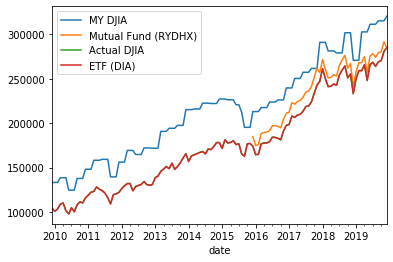

In [22]:
# Plotting my S&P 500, the actual S&P 500 Index, a Mutual Fund, and an ETF
my_dj["price weight"].plot(label="MY DJIA")
dj_mutual["mnav"].plot(label="Mutual Fund (RYDHX)")
dj_index["price adjusted"].plot(label="Actual DJIA")
dj_etf["price adjusted"].plot(label="ETF (DIA)")
legend(loc="best")

In the above plot, the ETF (red line) and the actual DJIA Index (green line) are very closely related which makes the actual DJIA Index difficult to see on the plot.

***Note: the values in the above plot were scaled so that we are able to see the relationships/trends between one another***

In [23]:
# Correlation matrix between my DJIA, the actual DJIA Index, a Mutual Fund, and an ETF
dj_return_corr = pd.DataFrame(data={"My DJIA":my_dj["return"], "Mutual Fund (RYDHX)":dj_mutual["month ret"], "Actual DJIA":dj_index["return"], "ETF (DIA)":dj_etf["return"]})
dj_return_corr.corr()

,My DJIA,Mutual Fund (RYDHX),Actual DJIA,ETF (DIA)
My DJIA,1.000000,0.296089,0.337793,0.329099
Mutual Fund (RYDHX),0.296089,1.000000,0.999175,0.999399
Actual DJIA,0.337793,0.999175,1.000000,0.999498
ETF (DIA),0.329099,0.999399,0.999498,1.000000
